<a href="https://colab.research.google.com/github/Lianyihwei/RobbiLian/blob/master/FinanceWithPython_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Back Testing 策略回測
前一篇整理使用python下載並計算幾個常用的技術分析指標  
這一篇將利用這些指標，回測幾檔股票的表現狀況  
同時pyhton也有許多方便好用的library，本篇將使用vectotbt、pandas-ta這2個好用的library

In [ ]:
!pip install yfinance
!pip install vectorbt
!pip install backtesting
!pip install pandas-ta
!pip install -U kaleido
"""
下面這段是google 安裝Ta-Lib的方式
"""
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

## PART.1 單一指標策略回測 <RSI>
回測 RSI > 70 賣出 、RSI < 30 買入  
本例使用3009大立光5年的資料回測

In [ ]:
import yfinance as yf
import pandas as pd
#利用yfinance下整資料
df = yf.download("3008.tw", period="max", interval="1d", missing_index="drop")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-03-11,154.696198,154.696198,154.696198,154.696198,103.021194,1415
2002-03-12,89.815620,89.815620,89.815620,89.815620,59.813446,2604
2002-03-13,95.954025,95.954025,95.954025,95.954025,63.901348,2604
2002-03-14,102.480934,102.480934,102.480934,102.480934,68.248032,2604
2002-03-15,103.250877,109.389282,103.250877,109.389282,72.848686,15631
...,...,...,...,...,...,...
2022-06-29,1690.000000,1710.000000,1680.000000,1700.000000,1700.000000,321380
2022-06-30,1685.000000,1735.000000,1670.000000,1725.000000,1725.000000,711306
2022-07-01,1725.000000,1750.000000,1685.000000,1690.000000,1690.000000,861991


使用pandas-ta計算RSI，[pandas-ta](https://twopirllc.github.io/pandas-ta/#momentum-41)  
使用vectorbt做為回測工具[Vectorbt API](https://vectorbt.dev/api/)連結    

    vectorbt也有串接yfinance，可用YFData.download下載Data，.get("Close")只下載收盤價  
    避免MetaData資料有遺失值，prams設missing_index="drop"

In [ ]:
import pandas_ta as ta
import vectorbt as vbt

# RSI計算，vectorbt及pandas_ta都有方法可以計算RSI指標
# vectotbt最神奇的地方是還連結了pandas_ta、talib、ta等計算技術指標的方法
# vbt計算RSI方法
rsi_vbt = vbt.RSI.run(df["Close"], window=14)
# vbt套用pandas_ta計算RSI方法，此例將使用pandas_ta的RSI
rsi_pandas_ta = vbt.pandas_ta("RSI", window=14).run(df["Close"])

print("vbt計算RSI方法：\n", rsi_vbt.rsi, "\n")
print("vbt套用pandas_ta計算RSI方法：\n", rsi_pandas_ta.rsi)

# 最後可以看到rsi_vbt及rsi_pandas_ta計算出的RSI不同
# 從vbt官方說明文件中得到他們計算RSI用的MA不同，vbt使用SMA 或 EMA, pandas_ta與TradingView都使用原Wilder's 的RMA

vbt計算RSI方法：
 Date
2002-03-11          NaN
2002-03-12          NaN
2002-03-13          NaN
2002-03-14          NaN
2002-03-15          NaN
                ...    
2022-06-29    34.482759
2022-06-30    40.229885
2022-07-01    42.168675
2022-07-04    50.574713
2022-07-05    55.813953
Name: (14, Close), Length: 5020, dtype: float64 

vbt套用pandas_ta計算RSI方法：
 Date
2002-03-11          NaN
2002-03-12          NaN
2002-03-13          NaN
2002-03-14          NaN
2002-03-15          NaN
                ...    
2022-06-29    51.959273
2022-06-30    54.838668
2022-07-01    50.293824
2022-07-04    55.410562
2022-07-05    57.504336
Name: Close, Length: 5020, dtype: float64


    建立策略進場(entries)與出場(exits)條件，當RSI往下跌破30時入場，往上漲過70出場
    用.stats()可查看策略完整資料，.total_return()查看策略總報酬

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2002-03-11 00:00:00
End                           2022-07-05 00:00:00
Period                                       5020
Start Value                                 100.0
End Value                              155.021362
Total Return [%]                        55.021362
Benchmark Return [%]                  1034.481667
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        65.193221
Max Drawdown Duration                      2834.0
Total Trades                                   18
Total Closed Trades                            17
Total Open Trades                               1
Open Trade PnL                          -1.766625
Win Rate [%]                            52.941176
Best Trade [%]                          29.699248
Worst Trade [%]                         -34.67649
Avg Winning Trade [%]                   19.975559
Avg Losing Trade [%]                   -14.813178


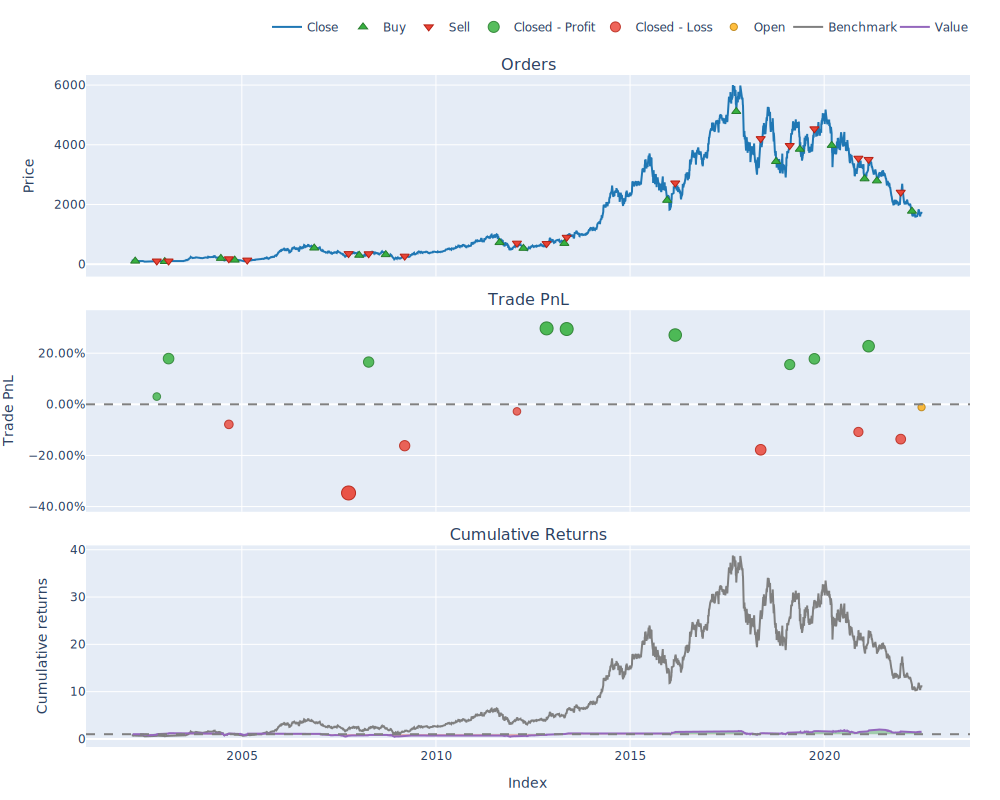

'\n從上市到20222-07-04共有5019筆資料，以RSI < 30 買進 RSI > 70 賣出策略共進行了18次交易，有1次交易還沒平倉\n勝率約53%，獲利的交易平均報酬率約20%，虧損交易平均報酬約為-35%\n雖然勝率超過5成，但從下圖可看到這個策略的盲點是股貨在大趨勢上漲階段，等不到RSI < 30的訊號，無法享受大波段上漲的獲利\n但反過來說，當股價處在大波段下跌趨勢時也有機會跳過大損失\n'

In [ ]:
# vbt回測語法很簡單，先建立入場的條件與出場條件(entries，exits)
entries = rsi_pandas_ta.rsi_crossed_below(30)
exits = rsi_pandas_ta.rsi_crossed_above(70)

# 再將收盤價, 入場條件，出場條件帶入Portfolio.from_signals()中就完成了一次簡單的回測
pf = vbt.Portfolio.from_signals(df["Close"], entries, exits)

# pf.stats可差出回測的所有資訊
# 常用的有總報酬與buy&hold報酬(Benchmark Return [%])，總交易次數等
print(pf.stats())

# vbt結合plotly繪圖模組，簡單產出互動式圖表
pf.plot(width=1000, height=800).show("svg")

'''
從上市到20222-07-04共有5019筆資料，以RSI < 30 買進 RSI > 70 賣出策略共進行了18次交易，有1次交易還沒平倉
勝率約53%，獲利的交易平均報酬率約20%，虧損交易平均報酬約為-35%
雖然勝率超過5成，但從下圖可看到這個策略的盲點是股貨在大趨勢上漲階段，等不到RSI < 30的訊號，無法享受大波段上漲的獲利
但反過來說，當股價處在大波段下跌趨勢時也有機會跳過大損失
'''

### 單一指標回測 MACD
DIF（快線）向上突破 MACD（慢線）買進  
DIF（快線）向下跌破 MACD（慢線）賣出

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2002-03-11 00:00:00
End                           2022-07-05 00:00:00
Period                                       5020
Start Value                                 100.0
End Value                              565.107828
Total Return [%]                       465.107828
Benchmark Return [%]                  1034.481667
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        57.027825
Max Drawdown Duration                      1821.0
Total Trades                                  151
Total Closed Trades                           150
Total Open Trades                               1
Open Trade PnL                           9.659963
Win Rate [%]                            41.333333
Best Trade [%]                          38.211164
Worst Trade [%]                        -15.306122
Avg Winning Trade [%]                   10.265711
Avg Losing Trade [%]                    -4.659647


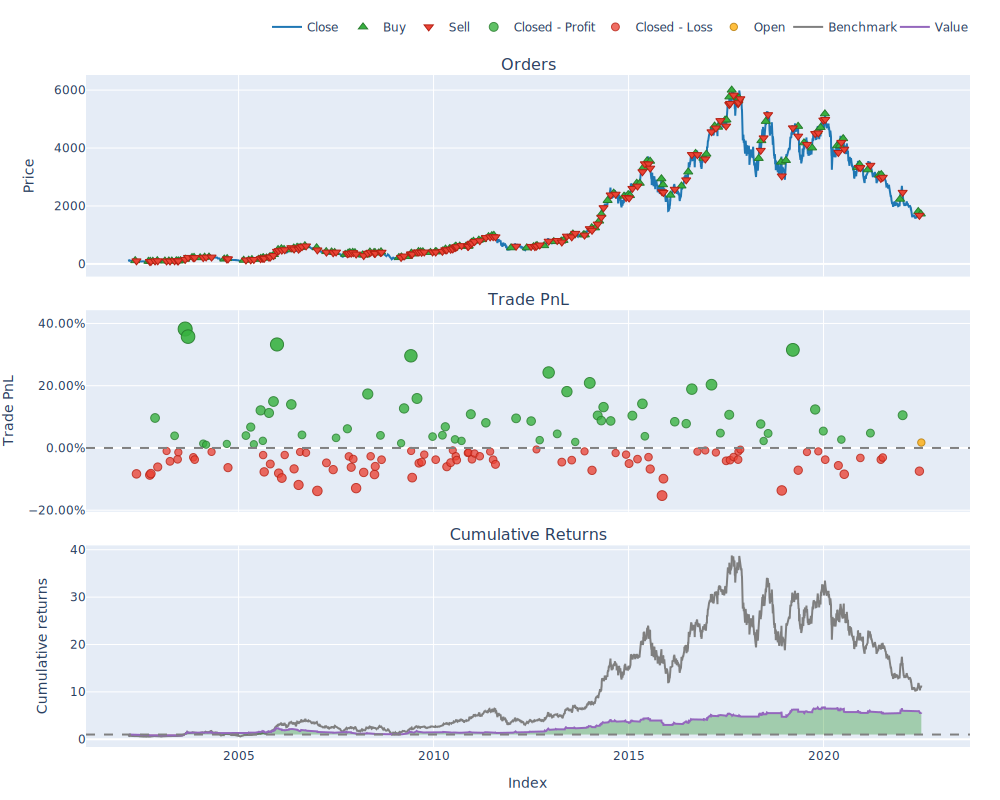

In [ ]:
# 使用pandas_ta計算出MACD的值
# 設定進場條件為macd大於0，且向上突破macd_signal
# 出場條件為macd小於0，且向下跌破macd_signal
# 此處要留意如果是用vbt.MACD.run 方法取MACD
# 要用macd.signal 取代 macd_pandas.macds
macd_pandas = vbt.pandas_ta("MACD").run(df["Close"])
entris = macd_pandas.macd_above(0) & macd_pandas.macd_above(macd_pandas.macds)
exits = macd_pandas.macd_below(0) | macd_pandas.macd_below(macd_pandas.macds)
pf = vbt.Portfolio.from_signals(df["Close"], entris, exits)
print(pf.stats())
pf.plot(width=1000, height=800).show("svg")

'''
不清楚vbt的計算值總是與pandas_ta有出入
目前較主流的回測工具是tradingview，而tradingview的結果與pandas_ta幾乎相同
所以我還是儘量用pandas_ta計算回測要用的各種指標
'''

## 單一指標、多檔股票回測

In [ ]:
# vectorbt也可以同時輸入多檔股票針對以相同模型回測
datas = vbt.YFData.download(["0050.tw", "2303.tw", "2603.tw", "2002.tw", "1301.tw"],
                                   period="3y", intervals="1d",
                                   missing_index="drop").get("Close")
rsi = vbt.pandas_ta("RSI", window=14).run(datas)
entries = rsi.rsi_crossed_below(30)
exits = rsi.rsi_crossed_above(70)
pf = vbt.Portfolio.from_signals(datas, entries, exits)

# 使用Portfolio.total_return()可以列出報酬總表
print(pf.total_return())

symbol
0050.tw   -0.000014
2303.tw   -0.216485
2603.tw    0.990582
2002.tw   -0.157768
1301.tw    0.066189
Name: total_return, dtype: float64


PART.2 自定義指標回測
    使用rsi來說明自定義指標的方法
    先定義指標方法，再設定回傳內容後再得到結果

In [4]:
import vectorbt as vbt
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime

end_time = datetime.datetime.today()
start_time = end_time - datetime.timedelta(365*5)
ticker = vbt.YFData.download("0050.tw", start=start_time, end=end_time,
                                                             missing_index="drop").get("Close")

print(ticker)
# 自定義指標
def custom_indicator(close, window=14):
    rsi = vbt.pandas_ta("RSI", window=window).run(ticker)
    return rsi.rsi
 
# 自定義指標產出內容，同時告訴vbt產出的方式是透過自定義的指標
custom_ind = vbt.IndicatorFactory(
            class_name="Combination",
            short_name="Comb",
            input_names=["close"],
            param_names=["window"],
            output_names=["value"]
            ).from_apply_func(
                            custom_indicator,
                            window=14
                            )
# 使用自定義的rsi來產出rsi，此處將window設為21，如不指定window是自定義的default的14天
res = ind.run(close_prices, window=21)

print(res.value.head(25))

## 複數指標回測，RSI + MA

In [ ]:
from pandas.core.arrays import interval
import vectorbt as vbt
import pandas as pd
import numpy as np

close_prices = vbt.YFData.download("0050.tw", period="max", interval="1d",
                                                             missing_index="drop").get("Close")

# 自定義指標
def custom_indicator(close, rsi_window=14, ma_window=60):
    rsi = vbt.RSI.run(close, window=rsi_window).rsi.to_numpy()
    ma = vbt.MA.run(close, window=ma_window).ma.to_numpy()
    trend = np.where(rsi>70, -1, 0)
    trend = np.where((rsi<30) & (close<ma), 1, trend)
    return trend

# 自定義指標產出內容，同時告訴vbt產出的方式是透過自定義的指標
ind = vbt.IndicatorFactory(
            class_name="Combination",
            short_name="Comb",
            input_names=["close"],
            param_names=["rsi_window", "ma_window"],
            output_names=["value"]
            ).from_apply_func(
                            custom_indicator,
                            rsi_window=14,
                            ma_window=60
                            )
# 使用自定義的rsi來產出rsi，此處將window設為21，如不指定window是自定義的default的14天
res = ind.run(close_prices, 
              rsi_window=21, 
              ma_window=60)

entris = res.value == 1.0
exits = res.value == -1.0
pf = vbt.Portfolio.from_signals(close_prices, entris, exits)
print(pf.stats())

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.7/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2008-01-02 00:00:00+00:00
End                           2022-07-01 00:00:00+00:00
Period                                             3565
Start Value                                       100.0
End Value                                     74.658637
Total Return [%]                             -25.341363
Benchmark Return [%]                          85.885696
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              50.774412
Max Drawdown Duration                            3453.0
Total Trades                                         20
Total Closed Trades                                  19
Total Open Trades                                     1
Open Trade PnL                                -18.23799
Win Rate [%]                                  73.684211
Best Trade [%]                                 9.644266
Worst Trade [%]                              -37

In [ ]:
from pandas.core.arrays import interval
import vectorbt as vbt
import pandas as pd
import numpy as np

close_prices = vbt.YFData.download("0050.tw", period="7d", interval="1m",
                                                             missing_index="drop").get("Close")

# 自定義指標
def custom_indicator(close, rsi_window=14, ma_window=60):
    close_5m = close.resample("5T").last()
    rsi = vbt.RSI.run(close_5m, window=rsi_window).rsi
    rsi.columns = rsi.columns.droplevel()
    rsi, _ = rsi.align(close, broadcast_axis=0, method="ffill", join="right")
    close = close.to_numpy()
    rsi = rsi.to_numpy()
    ma = vbt.MA.run(close, window=ma_window).ma.to_numpy()
    trend = np.where(rsi>70, -1, 0)
    trend = np.where((rsi<30) & (close<ma), 1, trend)
    return 1

# 自定義指標產出內容，同時告訴vbt產出的方式是透過自定義的指標
ind = vbt.IndicatorFactory(
            class_name="Combination",
            short_name="Comb",
            input_names=["close"],
            param_names=["rsi_window", "ma_window"],
            output_names=["value"]
            ).from_apply_func(
                            custom_indicator,
                            rsi_window=14,
                            ma_window=60,
                            keep_pd=True
                            )
# 使用自定義的rsi來產出rsi，此處將window設為21，如不指定window是自定義的default的14天
res = ind.run(close_prices, 
              rsi_window=21, 
              ma_window=60)

entris = res.value == 1.0
exits = res.value == -1.0
pf = vbt.Portfolio.from_signals(close_prices, entris, exits)
print(pf.stats())

                               Close
Datetime                            
2022-06-23 01:00:00+00:00        NaN
2022-06-23 01:01:00+00:00        NaN
2022-06-23 01:02:00+00:00        NaN
2022-06-23 01:03:00+00:00        NaN
2022-06-23 01:04:00+00:00        NaN
...                              ...
2022-07-01 05:21:00+00:00  30.357245
2022-07-01 05:22:00+00:00  30.357245
2022-07-01 05:23:00+00:00  30.357245
2022-07-01 05:24:00+00:00  30.357245
2022-07-01 05:30:00+00:00  30.357245

[1839 rows x 1 columns]
                                Close
Datetime                             
2022-06-23 01:00:00+00:00  119.599998
2022-06-23 01:01:00+00:00  119.650002
2022-06-23 01:02:00+00:00  119.449997
2022-06-23 01:03:00+00:00  119.250000
2022-06-23 01:04:00+00:00  119.199997
...                               ...
2022-07-01 05:21:00+00:00  111.400002
2022-07-01 05:22:00+00:00  111.300003
2022-07-01 05:23:00+00:00  111.349998
2022-07-01 05:24:00+00:00  111.250000
2022-07-01 05:30:00+00:00  111.550003


AssertionError: ignored

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.test import GOOG
from backtesting.lib import crossover
import talib as ta

class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    def init(self):
        self.rsi = self.I(ta.RSI, self.data["Close"], 14)
    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

bt = Backtest(GOOG, RsiOscillator, cash=10_000)
stats = bt.run()
print(stats)

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   29.329609
Equity Final [$]                      15677.5
Equity Peak [$]                       15835.7
Return [%]                             56.775
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                    5.416737
Volatility (Ann.) [%]               23.502544
Sharpe Ratio                         0.230475
Sortino Ratio                        0.386423
Calmar Ratio                         0.110499
Max. Drawdown [%]                  -49.020734
Avg. Drawdown [%]                   -6.135224
Max. Drawdown Duration     1603 days 00:00:00
Avg. Drawdown Duration       94 days 00:00:00
# Trades                                   10
Win Rate [%]                             80.0
Best Trade [%]                      21.397983
Worst Trade [%]                    -20.449092
Avg. Trade [%]                    

In [ ]:
 bt.plot()

Row(id='1460', ...)

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.test import GOOG
from backtesting.lib import crossover
import talib as ta

def optim_func(series):
    return series["Return [%]"] / series["Exposure Time [%]"]

class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    def init(self):
        self.rsi = self.I(ta.RSI, self.data.Close, self.rsi_window)
    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

bt = Backtest(GOOG, RsiOscillator, cash=10_000)

stats = bt.optimize(
                    upper_bound = range(50, 85, 5),
                     lower_bound = range(10, 45, 5),
                     rsi_window = range(10, 30, 2),
                     maximize = optim_func,
                    constraint = lambda param: param.upper_bound > param.lower_bound)
print(stats)
bt.plot()

/usr/local/lib/python3.7/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 490 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   78.957169
Equity Final [$]                     47429.25
Equity Peak [$]                       47963.2
Return [%]                           374.2925
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   20.036325
Volatility (Ann.) [%]               36.471526
Sharpe Ratio                         0.549369
Sortino Ratio                        1.034397
Calmar Ratio                         0.332359
Max. Drawdown [%]                  -60.285274
Avg. Drawdown [%]                   -4.902585
Max. Drawdown Duration      786 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                                   10
Win Rate [%]                             90.0
Best Trade [%]                      46.583001
Worst Trade [%]                     -0.841216
Avg. Trade [%]                    

Row(id='4648', ...)

In [ ]:
bt.plot()

Row(id='2257', ...)

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover


In [ ]:
df = yf.download("BTC-USD", start="2020-02-01", end="2021-01-21")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-01,9346.357422,9439.323242,9313.239258,9392.875000,9392.875000,25922656496
2020-02-02,9389.820312,9468.797852,9217.824219,9344.365234,9344.365234,30835736946
2020-02-03,9344.683594,9540.372070,9248.633789,9293.521484,9293.521484,30934096509
2020-02-04,9292.841797,9331.265625,9112.811523,9180.962891,9180.962891,29893183716
2020-02-05,9183.416016,9701.299805,9163.704102,9613.423828,9613.423828,35222060874


In [ ]:
class sma_crossover(Strategy):
    def init(self):
        price = self.df["Close"]
        self.sma_short = self.I(df.ta.SMA(5), price)
        

In [9]:
def find_cd(a):
    cd_list=[]
    for x in range(1, (a + 1)):
        print("a:",a)
        print("x:",x)
        ans = a % x
        if ans == 0:
            print("ans =  0:",ans)
            cd_list.append(x)
        else:
            print("ans != 0")
        print()
    return cd_list
find_cd(60)

a: 60
x: 1
ans =  0: 0

a: 60
x: 2
ans =  0: 0

a: 60
x: 3
ans =  0: 0

a: 60
x: 4
ans =  0: 0

a: 60
x: 5
ans =  0: 0

a: 60
x: 6
ans =  0: 0

a: 60
x: 7
ans != 0

a: 60
x: 8
ans != 0

a: 60
x: 9
ans != 0

a: 60
x: 10
ans =  0: 0

a: 60
x: 11
ans != 0

a: 60
x: 12
ans =  0: 0

a: 60
x: 13
ans != 0

a: 60
x: 14
ans != 0

a: 60
x: 15
ans =  0: 0

a: 60
x: 16
ans != 0

a: 60
x: 17
ans != 0

a: 60
x: 18
ans != 0

a: 60
x: 19
ans != 0

a: 60
x: 20
ans =  0: 0

a: 60
x: 21
ans != 0

a: 60
x: 22
ans != 0

a: 60
x: 23
ans != 0

a: 60
x: 24
ans != 0

a: 60
x: 25
ans != 0

a: 60
x: 26
ans != 0

a: 60
x: 27
ans != 0

a: 60
x: 28
ans != 0

a: 60
x: 29
ans != 0

a: 60
x: 30
ans =  0: 0

a: 60
x: 31
ans != 0

a: 60
x: 32
ans != 0

a: 60
x: 33
ans != 0

a: 60
x: 34
ans != 0

a: 60
x: 35
ans != 0

a: 60
x: 36
ans != 0

a: 60
x: 37
ans != 0

a: 60
x: 38
ans != 0

a: 60
x: 39
ans != 0

a: 60
x: 40
ans != 0

a: 60
x: 41
ans != 0

a: 60
x: 42
ans != 0

a: 60
x: 43
ans != 0

a: 60
x: 44
ans != 0

a: 60
x:

[1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]